<h1 align="center">Deep learning a gyakorlatban Python és LUA alapon | VITMAV45</h1>
<h2 align="center">Nagy házi feladat</h2>

Team: Molehub

Team members:
* Küttel Dániel (QPPXW1) email:kutteljr@gmail.com
* Siket Máté (N1C4Z9) email:siket.mate@gmail.com


Topic: Mole detection with deep learning

<h2 align="center">I. milestone</h2>

### 1.1 Motivation
The current neural networks are developed for diagnose melanoma based on dermatoscopic images. On the other hand, during consultations we determined a different kind of approach. Our goal is to mark the moles on pictures which are taken from different distances at different angles, resolutions and lighting conditions. The "cutouts" could be later used for detailed investigation or mole appareance follow-up.

### 1.2 Main tasks during the semester
* Data acquistion & preprocess
* Train
* Data augmentation
* Hyperparameter tuning

Regarding the <i>I. milestone</i> our task is invloving data acquisiton, labeling, preprocessing standardization and in general to make an organized dataset which will be later applicable for training purposes.

### 1.3 Data acquistion & preprocess
In our case we could not find any perfect database that fits our problem, so we decided to collect photos from the internet and labeled them.

#### 1.3.1 Data acquistion and labeling
Some examples from our raw database:

Libraries for reading and plotting images:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Following code reads two examples from our raw database.

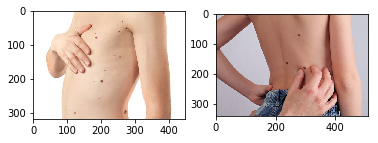

In [2]:
example_img1=plt.imread('DataBase1/14.jpg')
example_img2=plt.imread('DataBase1/176.jpg')
figure = plt.figure()
figure.add_subplot(1,2,1)
plt.imshow(example_img1)
figure.add_subplot(1,2,2)
plt.imshow(example_img2)
plt.show()

For labeling purposes we used the labelImg software, which can be found https://github.com/tzutalin/labelImg here. The outputs are .xml files which contain the corresponding file name, resolution, path, bounding boxes of the selected image regions. Until the writing of this document we labeled more than 300 images, containing more than a 1000 moles.

#### 1.3.2 Preprocessing

We imported the following libraries for preprocessing purposes:

In [2]:
from PIL import Image
import os
import xml.etree.ElementTree as ET

The following code iterates through our collected and labeled images. In the process we crop the moles and save them into separate files based on the previously generated .xml files. The cropped images also rescaled, thus the output images become 32x32 3-channel 8bit images in .bmp file format.

In [3]:
i_mole = 1
for i_database in range(1,3):#iterating through our databases
    for i_image in range(1,250):#iterating through the images
        if os.path.exists('DataBase%d/%d.xml' % (i_database, i_image)):#checking existance of file
            tree = ET.parse('DataBase%d/%d.xml' % (i_database, i_image))#reading the i-th .xml files
            root = tree.getroot()
            img = Image.open('DataBase%d/%d.jpg' % (i_database, i_image))#reading the i-th image
            for mole in root.findall('object'):#iterating through the labeled objects
                box = mole.find('bndbox')#acquiring the bounding box of the mole
                xmin = int(box.find('xmin').text)
                xmax = int(box.find('xmax').text)
                ymax = int(box.find('ymax').text)
                ymin = int(box.find('ymin').text)
                area = (xmin, ymin, xmax, ymax)
                cropped_img = img.crop(area)#cropping the image
                cropped_img = cropped_img.resize((32,32))#resizing the image
                cropped_img.save('Cropped/%d.bmp' % (i_mole))#saving the image
                i_mole += 1

We present two examples of the cropped moles:

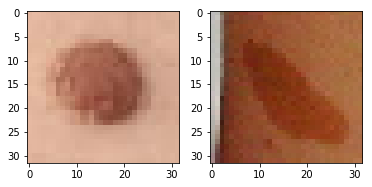

In [4]:
example_mole1=plt.imread('Cropped/8.bmp')
example_mole2=plt.imread('Cropped/810.bmp')
figure = plt.figure()
figure.add_subplot(1,2,1)
plt.imshow(example_mole1)
figure.add_subplot(1,2,2)
plt.imshow(example_mole2)
plt.show()

The following code iterates through the selected images, which will provide samples for non-mole elements. Notation for the background elements is (<i>bckg</i>). We distribute 56 points in one image evenly where we sample 32x32 regions. The cropped images checked afterwards for eliminate the unlikely events when the samples contain moles.

In [5]:
i_bckg = 1
for i_img in range(1,250):
    if os.path.exists('DataBaseBCKG/%d.jpg' % (i_img)):#checking existance of file
        img = Image.open('DataBaseBCKG/%d.jpg' % (i_img))#reading the i-th image
        width, height = img.size
        x_scale = int(width/8-1)#distance between samples in x direction
        y_scale = int(height/8-1)#distance between samples in y direction
        for x_point in range(1,8):
            for y_point in range(1,8):
                area = (x_point*x_scale-16, y_point*y_scale-16, x_point*x_scale+16, y_point*y_scale+16)#sampled area
                cropped_img = img.crop(area)#cropping the image
                cropped_img.save('CroppedBCKG/%d.bmp' % (i_bckg))#saving the image
                i_bckg += 1

We present two examples of the non-mole cropped images:

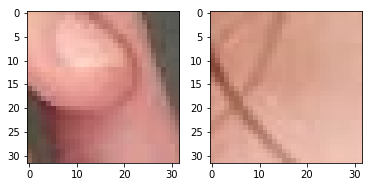

In [6]:
example_bckg1=plt.imread('CroppedBCKG/4.bmp')
example_bckg2=plt.imread('CroppedBCKG/117.bmp')
figure = plt.figure()
figure.add_subplot(1,2,1)
plt.imshow(example_bckg1)
figure.add_subplot(1,2,2)
plt.imshow(example_bckg2)
plt.show()

#### 1.3.3 Data organization and standardization

Libraries for creating the tuple dataset:

In [7]:
import numpy as np
from random import shuffle
import glob

The following code reads the cropped images and organizes into a random sequenced tuple structure based on the label.

It is a mole.


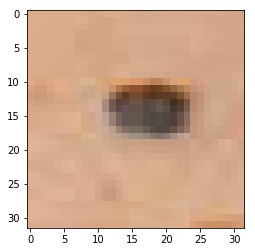

In [8]:
dataset = np.empty((1,2))
i_file = 1
for file_path in glob.glob('Cropped/*.bmp'):  #grabbing path of the cropped images
    bckg_path = ('CroppedBCKG/%d.bmp' % i_file) #grabbing path of the background images
    if file_path and bckg_path:
        dataset = np.append(dataset, [[plt.imread(file_path).astype(int), 1]], axis=0)  #reading mole images and labels
        dataset = np.append(dataset, [[plt.imread(bckg_path).astype(int), 0]], axis=0) #reading background images and labels
    i_file += 1
    
dataset = dataset[1:]
    
np.random.shuffle(dataset)#randomize the dataset

#Example:
#First dim: i-th image
#Second dim: 0 - image data; 1 - label data
plt.imshow(dataset[1][0])
if dataset[1][1]==1:
    print('It is a mole.')
else:
    print('It is not a mole.')

In [9]:
dataset_tuple = (dataset[:, 0], dataset[:, 1])#organize the dataset into a tuple

The following code separates the dataset into validation, test and train subsets. Based on the training set standardization executed on the three sets, on each channel separately. After that the separated, standardized R, G , B channels rearranged.

In [10]:
from sklearn.preprocessing import StandardScaler

X, Y = dataset_tuple #separating inputs and outputs
print('X shape: ', X.shape)
print('Y shape: ', Y.shape)

test_split = 0.1 #ratio of test samples
valid_split = 0.1 #ratio of validation samples

#Indeces of the subsets
v_index = int(X.shape[0]*(1-valid_split-test_split))
t_index = int(X.shape[0]*(1-test_split))

#Splitting the dataset into test, validation and train subsets
X_test = X[t_index:]
Y_test = Y[t_index:]
X_valid = X[v_index:t_index]
Y_valid = Y[v_index:t_index]
X_train = X[:v_index]
Y_train = Y[:v_index]

#Checking the length of the subsets
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)
print('X_valid shape: ', X_valid.shape)
print('Y_valid shape: ', Y_valid.shape)
print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)

#Standardization
X_Train = []
X_Test = []
X_Valid = []

for i_channel in range(0,3): #iterating through the channels
    channel_train = [image[:,:,i_channel].astype('float64') for image in X_train]
    channel_test = [image[:,:,i_channel].astype('float64') for image in X_test]
    channel_valid = [image[:,:,i_channel].astype('float64') for image in X_valid]
    scaler = StandardScaler()
    X_Train.append([scaler.fit_transform(channel) for channel in channel_train])
    X_Test.append([scaler.transform(channel) for channel in channel_test])
    X_Valid.append([scaler.transform(channel) for channel in channel_valid])

#Rearranging the separated channels into 32x32x3 list
X_Train = [np.dstack((r,g,b)) for (r,g,b) in zip(X_Train[0],X_Train[1],X_Train[2])]
X_Test = [np.dstack((r,g,b)) for (r,g,b) in zip(X_Test[0],X_Test[1],X_Test[2])]
X_Valid = [np.dstack((r,g,b)) for (r,g,b) in zip(X_Valid[0],X_Valid[1],X_Valid[2])]

X shape:  (2794,)
Y shape:  (2794,)
X_test shape:  (280,)
Y_test shape:  (280,)
X_valid shape:  (279,)
Y_valid shape:  (279,)
X_train shape:  (2235,)
Y_train shape:  (2235,)


In [11]:
X_Test[0]

array([[[-3.18053289,  7.7632362 , -3.77964473],
        [-3.18053289,  7.7632362 , -3.77964473],
        [-3.72772135,  7.21604774, -4.53557368],
        ...,
        [ 5.37888249,  8.99953229, -1.54619807],
        [ 6.34047042,  8.60718211, -2.84825961],
        [ 6.34047042,  8.60718211, -2.84825961]],

       [[-3.18053289,  7.7632362 , -3.77964473],
        [-3.18053289,  7.7632362 , -3.77964473],
        [-3.72772135,  7.21604774, -4.53557368],
        ...,
        [ 5.37888249,  8.99953229, -1.54619807],
        [ 6.34047042,  8.60718211, -2.84825961],
        [ 6.34047042,  8.60718211, -2.84825961]],

       [[-4.82209825,  6.12167083, -7.55928946],
        [-4.82209825,  6.12167083, -7.55928946],
        [-4.82209825,  6.12167083, -7.55928946],
        ...,
        [ 7.30205835, 11.35363338,  1.057925  ],
        [ 6.98152904,  9.39188247, -1.98021858],
        [ 6.98152904,  9.39188247, -1.98021858]],

       ...,

       [[-2.63334444,  6.66885929, -4.53557368],
        [-2